# Prediction by Diagnosis Codes
In this notebook we use some fancier networks. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import os, sys

%matplotlib inline

In [2]:
path = '/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/NRD/'

In [2]:
path = '/nfs/turbo/umms-awaljee/wsliu/Data/NRD/'

In [3]:
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [4]:
from keras.layers import Input, Embedding, concatenate, Reshape, BatchNormalization, add, LSTM, CuDNNLSTM, CuDNNGRU, Lambda
from keras.models import Model
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam
import keras.backend as K

Using TensorFlow backend.


In [5]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from DL_utils import plot_roc
from keras_addon import AUCCheckPoint

## Data Preparation

In [6]:
core_dtypes_pd = {'AGE': float,
 'AWEEKEND': float,
 'DIED': float,
 'DISCWT': float,
 'DISPUNIFORM': float,
 'DMONTH': float,
 'DQTR': float,
 'DRG': float,
 'DRGVER': float,
 'DRG_NoPOA': float,
 'DX1': bytes,
 'DX10': bytes,
 'DX11': bytes,
 'DX12': bytes,
 'DX13': bytes,
 'DX14': bytes,
 'DX15': bytes,
 'DX16': bytes,
 'DX17': bytes,
 'DX18': bytes,
 'DX19': bytes,
 'DX2': bytes,
 'DX20': bytes,
 'DX21': bytes,
 'DX22': bytes,
 'DX23': bytes,
 'DX24': bytes,
 'DX25': bytes,
 'DX26': bytes,
 'DX27': bytes,
 'DX28': bytes,
 'DX29': bytes,
 'DX3': bytes,
 'DX30': bytes,
 'DX4': bytes,
 'DX5': bytes,
 'DX6': bytes,
 'DX7': bytes,
 'DX8': bytes,
 'DX9': bytes,
 'DXCCS1': float,
 'DXCCS10': float,
 'DXCCS11': float,
 'DXCCS12': float,
 'DXCCS13': float,
 'DXCCS14': float,
 'DXCCS15': float,
 'DXCCS16': float,
 'DXCCS17': float,
 'DXCCS18': float,
 'DXCCS19': float,
 'DXCCS2': float,
 'DXCCS20': float,
 'DXCCS21': float,
 'DXCCS22': float,
 'DXCCS23': float,
 'DXCCS24': float,
 'DXCCS25': float,
 'DXCCS26': float,
 'DXCCS27': float,
 'DXCCS28': float,
 'DXCCS29': float,
 'DXCCS3': float,
 'DXCCS30': float,
 'DXCCS4': float,
 'DXCCS5': float,
 'DXCCS6': float,
 'DXCCS7': float,
 'DXCCS8': float,
 'DXCCS9': float,
 'ECODE1': bytes,
 'ECODE2': bytes,
 'ECODE3': bytes,
 'ECODE4': bytes,
 'ELECTIVE': float,
 'E_CCS1': float,
 'E_CCS2': float,
 'E_CCS3': float,
 'E_CCS4': float,
 'FEMALE': float,
 'HCUP_ED': float,
 'HOSP_NRD': float,
 'KEY_NRD': float,
 'LOS': float,
 'MDC': float,
 'MDC_NoPOA': float,
 'NCHRONIC': float,
 'NDX': float,
 'NECODE': float,
 'NPR': float,
 'NRD_DaysToEvent': float,
 'NRD_STRATUM': float,
 'NRD_VisitLink': bytes,
 'ORPROC': float,
 'PAY1': float,
 'PL_NCHS': float,
 'PR1': bytes,
 'PR10': bytes,
 'PR11': bytes,
 'PR12': bytes,
 'PR13': bytes,
 'PR14': bytes,
 'PR15': bytes,
 'PR2': bytes,
 'PR3': bytes,
 'PR4': bytes,
 'PR5': bytes,
 'PR6': bytes,
 'PR7': bytes,
 'PR8': bytes,
 'PR9': bytes,
 'PRCCS1': float,
 'PRCCS10': float,
 'PRCCS11': float,
 'PRCCS12': float,
 'PRCCS13': float,
 'PRCCS14': float,
 'PRCCS15': float,
 'PRCCS2': float,
 'PRCCS3': float,
 'PRCCS4': float,
 'PRCCS5': float,
 'PRCCS6': float,
 'PRCCS7': float,
 'PRCCS8': float,
 'PRCCS9': float,
 'PRDAY1': float,
 'PRDAY10': float,
 'PRDAY11': float,
 'PRDAY12': float,
 'PRDAY13': float,
 'PRDAY14': float,
 'PRDAY15': float,
 'PRDAY2': float,
 'PRDAY3': float,
 'PRDAY4': float,
 'PRDAY5': float,
 'PRDAY6': float,
 'PRDAY7': float,
 'PRDAY8': float,
 'PRDAY9': float,
 'REHABTRANSFER': float,
 'RESIDENT': float,
 'SAMEDAYEVENT': bytes,
 'SERVICELINE': float,
 'TOTCHG': float,
 'YEAR': float,
 'ZIPINC_QRTL': float}

In [8]:
ami_index = pd.read_csv(path+'cohorts/ami_index.csv', dtype=core_dtypes_pd)

train_comorb = pd.read_csv(path+'cohorts/ami/comorb_train.csv')
tst_comorb = pd.read_csv(path+'cohorts/ami/comorb_tst.csv')

train_df = ami_index[ami_index['KEY_NRD'].isin(train_comorb['KEY_NRD'])]
tst_df = ami_index[ami_index['KEY_NRD'].isin(tst_comorb['KEY_NRD'])]

N_train = len(train_df)
N_tst = len(tst_df)
all_df = pd.concat([train_df, tst_df])

del(ami_index, train_comorb, tst_comorb)

In [9]:
trn_df, val_df = train_test_split(train_df, test_size=0.11, stratify=train_df.HOSP_NRD)
N_trn = len(trn_df)
N_val = len(val_df)

train_df = pd.concat([trn_df, val_df])

Define the dictionaries for DX, DX1 and hosp, from value to int. 

In [142]:
N_DX = 29
DXs = ['DX'+str(n) for n in range(2, N_DX+2)]

DX_series = pd.concat([all_df[DX] for DX in DXs])
DX_series = DX_series.fillna('missing')

rare_cutpoint = 50
code_freq = DX_series.value_counts()
rare_code = code_freq[code_freq<rare_cutpoint].index
DX_series.loc[DX_series.isin(rare_code)] = 'rare'

In [143]:
DX_series = DX_series.astype('category')

DX_cat = DX_series.cat.categories
n_DX_cat = len(DX_cat)
DX_series = DX_series.cat.rename_categories(range(n_DX_cat))

DX_dict = dict(zip(DX_cat, range(n_DX_cat)))

In [144]:
n_DX_cat

1339

In [14]:
DX1_series = all_df['DX1'].astype('category')
DX1_cat = DX1_series.cat.categories
DX1_int_cat = range(len(DX1_cat))

DX1_dict = dict(zip(DX1_cat, DX1_int_cat))

In [15]:
hosp_series = all_df['HOSP_NRD'].astype('category')
hosp_cat = hosp_series.cat.categories

hosp_dict = dict(zip(hosp_cat, range(len(hosp_cat))))

## LSTM with Raw ICD9 codes

In [106]:
N_DX = 29
DXs = ['DX'+str(n) for n in range(2, N_DX+2)]

In [145]:
DX_df = train_df[DXs]
DX_df = DX_df.fillna('missing')
DX_df[DX_df.isin(rare_code)] = 'rare'

for dx in DXs:
    DX_df[dx] = DX_df[dx].map(DX_dict)

DX_mat = DX_df.values
DX_mat_trn = DX_df.values[:N_trn, ]
DX_mat_val = DX_df.values[N_trn:, ]

In [20]:
DX_ohe = np.zeros((len(train_df), n_DX_cat))

for j in range(DX_mat.shape[0]):
    for i in range(DX_mat.shape[1]):
        DX_ohe[j, DX_mat[j, i]] = 1

DX_ohe_trn = DX_ohe[:N_trn, ]
DX_ohe_val = DX_ohe[N_trn:, ]

In [21]:
demo_mat = train_df[['AGE', 'FEMALE']].values

age_mean = train_df['AGE'].mean()
age_std = train_df['AGE'].std()

demo_mat[:, 0] = (demo_mat[:, 0]-age_mean)/age_std

demo_mat_trn = demo_mat[:N_trn, ]
demo_mat_val = demo_mat[N_trn:, ]

In [22]:
hosp_series = train_df['HOSP_NRD'].map(hosp_dict)
hosp_array = hosp_series.values

hosp_array_trn = hosp_array[:N_trn]
hosp_array_val = hosp_array[N_trn:]

In [23]:
DX1_series = train_df['DX1'].map(DX1_dict)

DX1_mat = np.zeros((len(DX1_series), len(DX1_dict)))
for i, dx1 in enumerate(DX1_series.values):
    DX1_mat[i, dx1] = 1

DX1_mat_trn = DX1_mat[:N_trn, ]
DX1_mat_val = DX1_mat[N_trn:, ]

In [24]:
y = train_df['readm30'].values.astype(int)

Y_trn = to_categorical(y[:N_trn])
Y_val = to_categorical(y[N_trn:])

### Model Building with Embedding

In [129]:
DX_embed_dim = 50
hosp_embed_dim = 1

In [146]:
input_DX = Input(shape = (N_DX,))
DX_embed = Embedding(input_dim=n_DX_cat, output_dim=DX_embed_dim, input_length=N_DX)(input_DX)

#DX_out, _, DX_feature = CuDNNLSTM(DX_embed_dim, return_sequences=False, return_state=True)(DX_embed)
#DX_feature = Lambda(lambda x: K.sum(x, axis=1))(DX_embed)
DX_feature = CuDNNLSTM(DX_embed_dim, return_sequences=False)(DX_embed)

input_demo = Input(shape=(2, ))

input_DX1 = Input(shape=(len(DX1_cat),))

input_hosp = Input(shape=(1,))
hosp_embed = Embedding(input_dim=len(hosp_cat), output_dim=hosp_embed_dim, input_length=1)(input_hosp)
hosp_embed = Reshape((hosp_embed_dim, ))(hosp_embed)

merged = concatenate([input_demo, input_DX1, DX_feature, hosp_embed], axis=1)

x = Dense(128, activation='relu')(merged)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)

prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=[input_demo, input_DX1, input_DX, input_hosp], outputs=prediction)

In [68]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 29)           0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 29, 50)       266400      input_17[0][0]                   
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 1)         869         input_20[0][0]                   
__________________________________________________________________________________________________
input_18 (

In [147]:
adam = Adam(lr=0.0002)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [148]:
checkpoint = ModelCheckpoint(filepath=model_path+'ami_icd9_lstm_valloss1.h5', save_best_only=True, save_weights_only=True)
auccheckpoint = AUCCheckPoint(filepath=model_path+'ami_icd9_lstm_auc1.h5', validation_y=Y_val[:, 1], 
                             validation_x=[demo_mat_val, DX1_mat_val, DX_mat_val, hosp_array_val])
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=1.e-8)
earlystop = EarlyStopping(monitor='val_loss', patience=20)

In [149]:
class_weight = {0:(Y_trn.shape[0]/sum(Y_trn[:, 0])), 1:(Y_trn.shape[0]/sum(Y_trn[:, 1]))}

In [150]:
hist = model.fit([demo_mat_trn, DX1_mat_trn, DX_mat_trn, hosp_array_trn], Y_trn, 
                 batch_size=512, epochs=20, callbacks=[checkpoint, auccheckpoint, reduce_lr, earlystop], class_weight=class_weight, 
                 validation_data=[[demo_mat_val, DX1_mat_val, DX_mat_val, hosp_array_val], Y_val], 
                verbose=1)

Train on 145667 samples, validate on 18004 samples
Epoch 1/20
145667/145667 [==============================] - 3s 23us/step - loss: 1.3184 - acc: 0.6007 - val_loss: 0.6395 - val_acc: 0.5991
AUC: 0.6896

Epoch 2/20
145667/145667 [==============================] - 2s 15us/step - loss: 1.2609 - acc: 0.6178 - val_loss: 0.6346 - val_acc: 0.6035
AUC: 0.6955

Epoch 3/20
145667/145667 [==============================] - 2s 15us/step - loss: 1.2497 - acc: 0.6205 - val_loss: 0.6506 - val_acc: 0.5970
AUC: 0.6957

Epoch 4/20
145667/145667 [==============================] - 2s 15us/step - loss: 1.2427 - acc: 0.6249 - val_loss: 0.6191 - val_acc: 0.6244
AUC: 0.6966

Epoch 5/20
145667/145667 [==============================] - 2s 15us/step - loss: 1.2401 - acc: 0.6250 - val_loss: 0.5905 - val_acc: 0.6412
AUC: 0.6957

Epoch 6/20
145667/145667 [==============================] - 2s 15us/step - loss: 1.2357 - acc: 0.6234 - val_loss: 0.6054 - val_acc: 0.6371
AUC: 0.6947

Epoch 7/20
145667/145667 [===========

### Model testing

In [151]:
DX_df_tst = tst_df[DXs]
DX_df_tst = DX_df_tst.fillna('missing')
DX_df_tst[DX_df_tst.isin(rare_code)] = 'rare'

for dx in DXs:
    DX_df_tst[dx] = DX_df_tst[dx].map(DX_dict)

DX_mat_tst = DX_df_tst.values

In [34]:
demo_mat_tst = tst_df[['AGE', 'FEMALE']].values
demo_mat_tst[:, 0] = (demo_mat_tst[:, 0]-age_mean)/age_std

In [35]:
hosp_array_tst = tst_df['HOSP_NRD'].map(hosp_dict).values

In [36]:
DX1_series_tst = tst_df.DX1.map(DX1_dict)

DX1_mat_tst = np.zeros((len(tst_df), len(DX1_dict)))
for i, dx1 in enumerate(DX1_series_tst.values):
    DX1_mat_tst[i, dx1] = 1

In [152]:
model.load_weights(model_path+'ami_icd9_lstm_auc1.h5')

In [153]:
y = model.predict([demo_mat_tst, DX1_mat_tst, DX_mat_tst, hosp_array_tst], verbose=1)

y_pred = y[:, 1]
y_true = tst_df.readm30.astype(int).values

18186/18186 [==============================] - 1s 58us/step


{0: 0.7063960981175992}

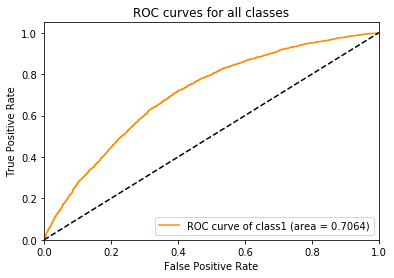

In [155]:
plot_roc(y_pred, y_true)

## Multi-Level CCS Codes

In [156]:
multi_ccs = pd.read_csv(path+'ccs_multi_dx_tool_2015.csv')

In [157]:
multi_ccs.columns = ['ICD9CM_CODE', 'CCS_LVL1', 'CCS_LVL1_LABEL', 'CCS_LVL2', 'CCS_LVL2_LABEL', 'CCS_LVL3', 'CCS_LVL3_LABEL', 
                    'CCS_LVL4', 'CCS_LVL4_LABEL']

In [158]:
multi_ccs.ICD9CM_CODE = multi_ccs.ICD9CM_CODE.apply(lambda x:x.replace("'", "").replace(' ', ''))
for j in range(1, 5):
    multi_ccs['CCS_LVL'+str(j)] = multi_ccs['CCS_LVL'+str(j)].apply(lambda x:x.replace("'", "").replace(' ', ''))

In [8]:
multi_ccs = multi_ccs[['ICD9CM_CODE', 'CCS_LVL1', 'CCS_LVL2', 'CCS_LVL3', 'CCS_LVL4']]

In [159]:
multi_ccs.shape

(15072, 9)

In [23]:
multi_ccs.CCS_LVL1_LABEL.value_counts()

Injury and poisoning                                                                 2764
Residual codes; unclassified; all E codes [259. and 260.]                            1589
Diseases of the nervous system and sense organs                                      1587
Infectious and parasitic diseases                                                    1226
Complications of pregnancy; childbirth; and the puerperium                           1205
Neoplasms                                                                            1114
Diseases of the musculoskeletal system and connective tissue                          863
Diseases of the digestive system                                                      757
Mental Illness                                                                        597
Diseases of the circulatory system                                                    553
Diseases of the genitourinary system                                                  498
Endocrine;

In [42]:
ami_ccs = multi_ccs.loc[multi_ccs.ICD9CM_CODE.isin(DX_cat)]

In [56]:
ami_ccs.shape

(5455, 9)

In [26]:
ccs_cat = pd.concat([ami_ccs.CCS_LVL1, ami_ccs.CCS_LVL2, ami_ccs.CCS_LVL3, ami_ccs.CCS_LVL4]).astype('category').cat.categories

In [16]:
# for all ccs category, not limited to ami
len(ccs_cat)

728

In [27]:
len(ccs_cat)

643

In [43]:
ami_ccs = ami_ccs.set_index(ami_ccs.ICD9CM_CODE, drop=True).drop(['ICD9CM_CODE'], axis=1)

In [50]:
ami_ccs['finest_non_empty'] = ami_ccs.CCS_LVL4
ami_ccs.finest_non_empty[ami_ccs.finest_non_empty==''] = ami_ccs.CCS_LVL3[ami_ccs.finest_non_empty == '']
ami_ccs.finest_non_empty[ami_ccs.finest_non_empty==''] = ami_ccs.CCS_LVL2[ami_ccs.finest_non_empty == '']
ami_ccs.finest_non_empty[ami_ccs.finest_non_empty==''] = ami_ccs.CCS_LVL1[ami_ccs.finest_non_empty == '']

In [34]:
parent_df = pd.DataFrame(dict(code=np.concatenate([DX_cat.values, ccs_cat.values]), parent = [0]*(len(ccs_cat)+len(DX_cat))))

In [63]:
DX_parent_df = pd.DataFrame(dict(code=DX_cat))
CCS_parent_df = pd.DataFrame(dict(code=ccs_cat))

In [71]:
DX_parent_df['parent_code'] = ami_ccs.loc[DX_parent_df.code, 'finest_non_empty'].values

/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/pandas/core/indexing.py:1027: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


In [72]:
DX_parent_df

,code,parent_code
0,0030,9.1
1,0031,1.1.2.5
2,0039,9.1
3,0040,9.1
4,0048,9.1
5,0050,9.1
6,00589,9.1
7,0059,9.1
8,0066,9.1
9,0071,9.1


In [67]:
ami_ccs.loc[DX_parent_df.code, 'finest_non_empty']

/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/pandas/core/indexing.py:1027: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


ICD9CM_CODE
0030           9.1
0031       1.1.2.5
0039           9.1
0040           9.1
0048           9.1
0050           9.1
00589          9.1
0059           9.1
0066           9.1
0071           9.1
0074           9.1
00800          9.1
00804          9.1
0082           9.1
00843          9.1
00845          9.1
00846          9.1
0085           9.1
00863          9.1
00869          9.1
0088           9.1
0090           9.1
0091           9.1
0092           9.1
0093           9.1
01120        1.1.1
01180        1.1.1
01190        1.1.1
01191        1.1.1
01193        1.1.1
            ...   
V8545       3.11.2
V860            18
V861            18
V8702           18
V8709           18
V8719           18
V872            18
V8731           18
V8739           18
V8741           18
V8743           18
V8744           18
V8745           18
V8746           18
V8749           18
V8801           18
V8802           18
V8803           18
V8811           18
V8812           18
V8822         13.9


In [57]:
len(DX_cat), len(ccs_cat)

(5458, 643)

In [58]:
parent_df = parent_df.dropna(subset=['code'])

In [60]:
parent_df.shape

(6101, 2)

In [ ]:
for code in parent_df.code:
    parent_code = ami_ccs[code, 'finest_non_empty']

In [55]:
ami_ccs.loc[parent_df.code, 'finest_non_empty']

/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/pandas/core/indexing.py:1027: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


ICD9CM_CODE
0030           9.1
0031       1.1.2.5
0039           9.1
0040           9.1
0048           9.1
0050           9.1
00589          9.1
0059           9.1
0066           9.1
0071           9.1
0074           9.1
00800          9.1
00804          9.1
0082           9.1
00843          9.1
00845          9.1
00846          9.1
0085           9.1
00863          9.1
00869          9.1
0088           9.1
0090           9.1
0091           9.1
0092           9.1
0093           9.1
01120        1.1.1
01180        1.1.1
01190        1.1.1
01191        1.1.1
01193        1.1.1
            ...   
9.6.1.3        NaN
9.6.1.4        NaN
9.6.2          NaN
9.6.3          NaN
9.6.3.1        NaN
9.6.3.2        NaN
9.6.3.3        NaN
9.6.3.4        NaN
9.6.4          NaN
9.6.4.1        NaN
9.6.4.2        NaN
9.6.5          NaN
9.6.6          NaN
9.7            NaN
9.7.1          NaN
9.7.2          NaN
9.7.3          NaN
9.7.4          NaN
9.7.5          NaN
9.7.6          NaN
9.8            NaN


In [35]:
parent_df

,code,parent
0,0030,0
1,0031,0
2,0039,0
3,0040,0
4,0048,0
5,0050,0
6,00589,0
7,0059,0
8,0066,0
9,0071,0


### Backups

### Model Building with OHE

In [20]:
DX_embed_dim = 50
hosp_embed_dim = 1

In [55]:
input_DX = Input(shape = (n_DX_cat,))
DX_feature = Dense(DX_embed_dim, use_bias=False)(input_DX)

input_demo = Input(shape=(2, ))

input_DX1 = Input(shape=(len(DX1_cat),))

input_hosp = Input(shape=(1,))
hosp_embed = Embedding(input_dim=len(hosp_cat), output_dim=hosp_embed_dim, input_length=1)(input_hosp)
hosp_embed = Reshape((hosp_embed_dim, ))(hosp_embed)

merged = concatenate([input_demo, input_DX1, DX_feature, hosp_embed], axis=1)

x = Dense(128, activation='relu')(merged)
#x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
#x = Dense(16, activation='relu')(x)
x = Dropout(0.5)(x)

prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=[input_demo, input_DX1, input_DX, input_hosp], outputs=prediction)

In [56]:
DX_feature.shape

TensorShape([Dimension(None), Dimension(50)])

In [58]:
adam = Adam(lr=0.0002)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
checkpoint = ModelCheckpoint(filepath=model_path+'ami_icd9_ohe_valloss1.h5', save_best_only=True, save_weights_only=True)
auccheckpoint = AUCCheckPoint(filepath=model_path+'ami_icd9_ohe_auc1.h5', validation_y=Y_val[:, 1], 
                             validation_x=[demo_mat_val, DX1_mat_val, DX_ohe_val, hosp_array_val])
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=1.e-8)
earlystop = EarlyStopping(monitor='val_loss', patience=20)

In [60]:
class_weight = {0:(Y_trn.shape[0]/sum(Y_trn[:, 0])), 1:(Y_trn.shape[0]/sum(Y_trn[:, 1]))}

In [61]:
hist = model.fit([demo_mat_trn, DX1_mat_trn, DX_ohe_trn, hosp_array_trn], Y_trn, 
                 batch_size=512, epochs=20, callbacks=[checkpoint, auccheckpoint, reduce_lr, earlystop], class_weight=class_weight, 
                 validation_data=[[demo_mat_val, DX1_mat_val, DX_ohe_val, hosp_array_val], Y_val], 
                verbose=2)

Train on 145667 samples, validate on 18004 samples
Epoch 1/20
 - 7s - loss: 1.3245 - acc: 0.5939 - val_loss: 0.6438 - val_acc: 0.6399
AUC: 0.6854

Epoch 2/20
 - 9s - loss: 1.2781 - acc: 0.6356 - val_loss: 0.6329 - val_acc: 0.6380
AUC: 0.6898

Epoch 3/20
 - 9s - loss: 1.2583 - acc: 0.6404 - val_loss: 0.6276 - val_acc: 0.6399
AUC: 0.6901

Epoch 4/20
 - 9s - loss: 1.2450 - acc: 0.6460 - val_loss: 0.6301 - val_acc: 0.6279
AUC: 0.6871

Epoch 5/20
 - 9s - loss: 1.2293 - acc: 0.6470 - val_loss: 0.6398 - val_acc: 0.6230
AUC: 0.6841

Epoch 6/20
 - 9s - loss: 1.2162 - acc: 0.6539 - val_loss: 0.6214 - val_acc: 0.6377
AUC: 0.6814

Epoch 7/20
 - 9s - loss: 1.2016 - acc: 0.6574 - val_loss: 0.6104 - val_acc: 0.6439
AUC: 0.6778

Epoch 8/20
 - 9s - loss: 1.1875 - acc: 0.6590 - val_loss: 0.6120 - val_acc: 0.6417
AUC: 0.6747

Epoch 9/20
 - 9s - loss: 1.1727 - acc: 0.6650 - val_loss: 0.6097 - val_acc: 0.6387
AUC: 0.6750

Epoch 10/20
 - 9s - loss: 1.1610 - acc: 0.6660 - val_loss: 0.6189 - val_acc: 0.6329
A